# Business Problem

* To Analyze Twitter financial news and classify sentiments (e.g.,
Positive, Neutral, Negative) or financial impacts (e.g., Bullish,
Bearish).

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [3]:
train_df = pd.read_csv('train_data.csv')
valid_df = pd.read_csv("valid_data.csv")

# look at structure
print(train_df.head())
print(train_df.columns)

                                                text  label
0  Here are Thursday's biggest analyst calls: App...      0
1  Buy Las Vegas Sands as travel to Singapore bui...      0
2  Piper Sandler downgrades DocuSign to sell, cit...      0
3  Analysts react to Tesla's latest earnings, bre...      0
4  Netflix and its peers are set for a ‘return to...      0
Index(['text', 'label'], dtype='object')


# Exploratory data Analysis

## Univariate Analysis

In [4]:
# Combine train and validation for full EDA
df = pd.concat([train_df, valid_df], ignore_index=True)

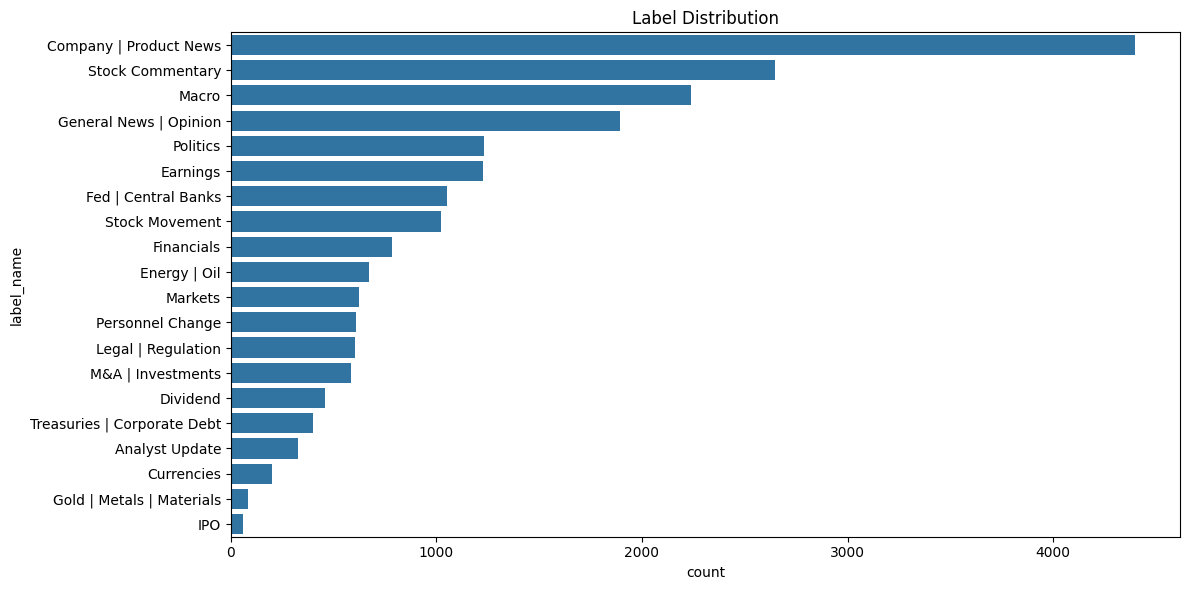

In [5]:
label_map = {0: "Analyst Update", 1: "Fed | Central Banks", 2: "Company | Product News",
             3: "Treasuries | Corporate Debt", 4: "Dividend", 5: "Earnings",
             6: "Energy | Oil", 7: "Financials", 8: "Currencies",
             9: "General News | Opinion", 10: "Gold | Metals | Materials",
             11: "IPO", 12: "Legal | Regulation", 13: "M&A | Investments",
             14: "Macro", 15: "Markets", 16: "Politics",
             17: "Personnel Change", 18: "Stock Commentary", 19: "Stock Movement"}

df['label_name'] = df['label'].map(label_map)

plt.figure(figsize=(12,6))
sns.countplot(y='label_name', data=df, order=df['label_name'].value_counts().index)
plt.title("Label Distribution")
plt.tight_layout()
plt.show()

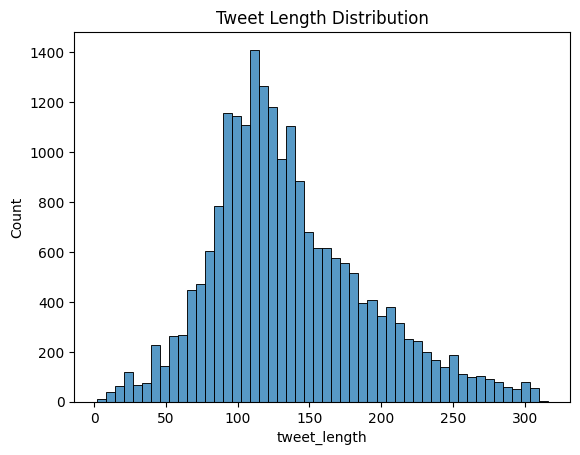

In [6]:
# Tweet length distribution
df['tweet_length'] = df['text'].apply(len)
sns.histplot(df['tweet_length'], bins=50)
plt.title("Tweet Length Distribution")
plt.show()

## Bivariate Analysis

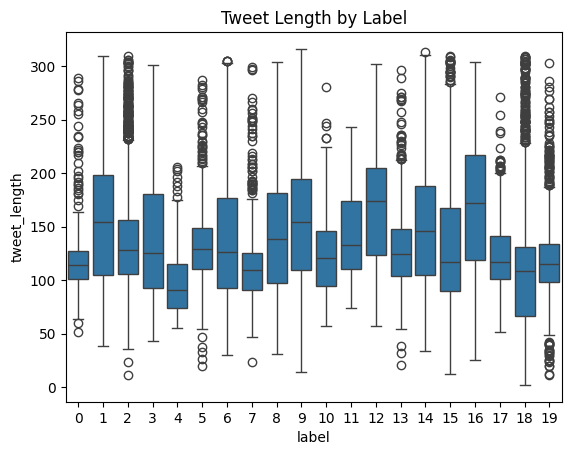

In [7]:
# Tweet length vs label
sns.boxplot(data=df, x='label', y='tweet_length')
plt.title("Tweet Length by Label")
plt.show()

## Multivariate Analysis

In [8]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable


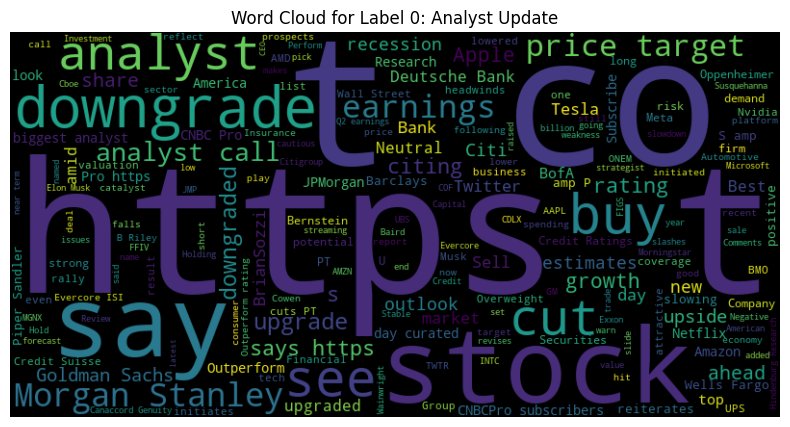

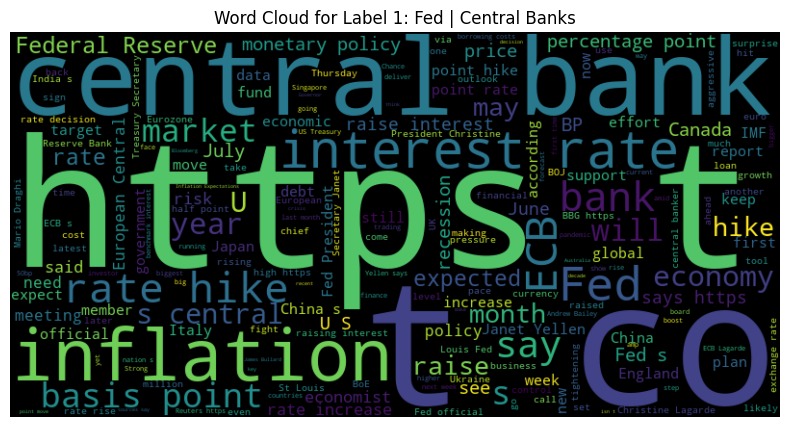

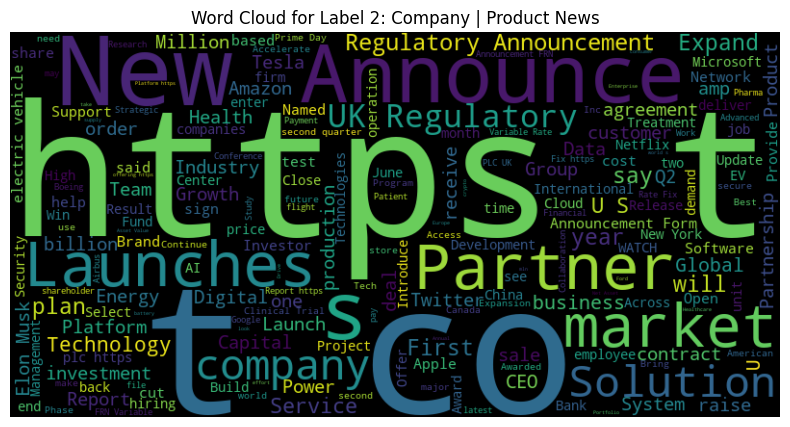

In [9]:
from wordcloud import WordCloud

for i in range(3):  # Loop over a few labels
    text = " ".join(df[df['label'] == i]['text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Label {i}: {label_map[i]}")
    plt.show()

# Data Preprocessing

## Handling Missing Values

In [10]:
df.isnull().sum()

text            0
label           0
label_name      0
tweet_length    0
dtype: int64

# Handling outliers

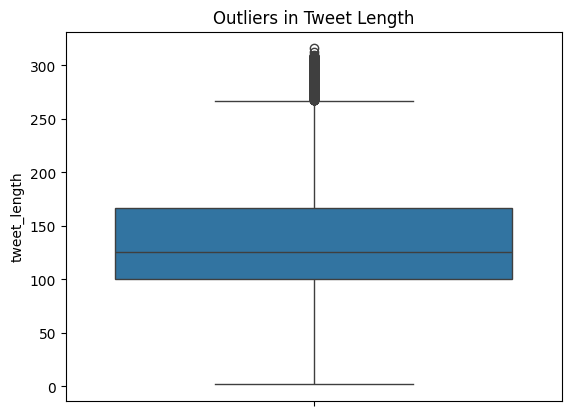

In [11]:
# Boxplot to detect
sns.boxplot(df['tweet_length'])
plt.title("Outliers in Tweet Length")
plt.show()

# Remove extreme outliers (optional)
q1 = df['tweet_length'].quantile(0.25)
q3 = df['tweet_length'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df = df[(df['tweet_length'] >= lower) & (df['tweet_length'] <= upper)]

# Categorical to numerical

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label_name'])  # Use this for modeling

# Text Vectorization

In [14]:
# Clean the tweets
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)     # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)    # Remove numbers, special chars
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()

# Scaling

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_length = scaler.fit_transform(df[['tweet_length']])

# Combine scaled tweet length with TF-IDF vectors
import numpy as np
X_final = np.hstack((X_tfidf, scaled_length))
y = df['label_encoded']

# Feature Engineering

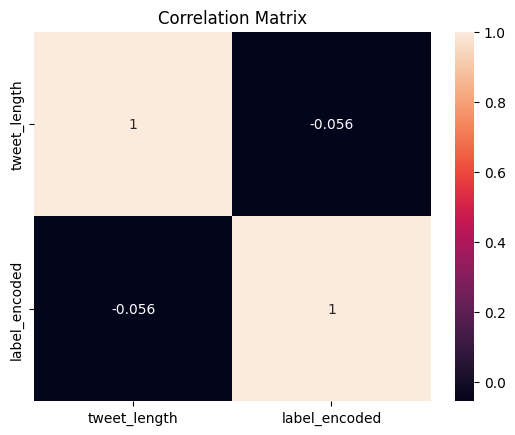

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df[['tweet_length', 'label_encoded']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [21]:
df.drop(['text', 'label', 'label_name'], axis=1, inplace=True)

# Train - Test Split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

# Machine Learning Models

In [23]:
from sklearn.metrics import classification_report, accuracy_score

## Logistic Regresssion

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=50)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.32      0.48        65
           1       0.69      0.90      0.78       868
           2       0.84      0.43      0.57        37
           3       0.96      0.93      0.94        91
           4       0.89      0.94      0.92       244
           5       0.82      0.65      0.72       130
           6       0.89      0.76      0.82       203
           7       0.90      0.74      0.81       156
           8       0.66      0.67      0.66       366
           9       1.00      0.12      0.22        16
          10       1.00      0.08      0.15        12
          11       0.92      0.62      0.74       117
          12       0.97      0.49      0.65       116
          13       0.73      0.80      0.76       433
          14       0.88      0.57      0.69       119
          15       0.97      0.75      0.85       121
          16       0.89      0.81      0.85       231
       

## Multinomial Naive Bayes (Great for text!)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_count = count_vect.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(X_count, df['label_encoded'], test_size=0.2, random_state=42)

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.71      0.20      0.31        60
           1       0.71      0.86      0.78       853
           2       1.00      0.07      0.13        29
           3       0.97      0.85      0.91       103
           4       0.92      0.89      0.90       253
           5       0.87      0.48      0.62       130
           6       0.83      0.79      0.81       208
           7       0.91      0.78      0.84       142
           8       0.72      0.73      0.73       394
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         9
          11       0.94      0.62      0.75       130
          12       0.96      0.37      0.53       119
          13       0.58      0.89      0.70       418
          14       0.75      0.34      0.47       105
          15       0.98      0.69      0.81       119
          16       0.89      0.87      0.88       245
          17       0.69    

## Support Vector Machine

In [29]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("SVM")
print(classification_report(y_test, y_pred_svc))

SVM
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        60
           1       0.83      0.86      0.84       853
           2       0.88      0.79      0.84        29
           3       0.98      0.95      0.97       103
           4       0.93      0.95      0.94       253
           5       0.82      0.85      0.83       130
           6       0.91      0.89      0.90       208
           7       0.81      0.87      0.84       142
           8       0.78      0.74      0.76       394
           9       0.70      0.70      0.70        10
          10       0.90      1.00      0.95         9
          11       0.93      0.83      0.88       130
          12       0.85      0.76      0.80       119
          13       0.80      0.83      0.81       418
          14       0.72      0.72      0.72       105
          15       0.86      0.85      0.86       119
          16       0.93      0.84      0.88       245
          17       0.79

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.35      0.51        60
           1       0.66      0.89      0.76       853
           2       0.89      0.55      0.68        29
           3       0.97      0.92      0.95       103
           4       0.91      0.96      0.93       253
           5       0.86      0.83      0.84       130
           6       0.90      0.84      0.87       208
           7       0.84      0.77      0.80       142
           8       0.79      0.60      0.69       394
           9       1.00      0.40      0.57        10
          10       1.00      0.56      0.71         9
          11       0.97      0.65      0.77       130
          12       0.95      0.50      0.66       119
          13       0.81      0.78      0.79       418
          14       0.79      0.58      0.67       105
          15       0.88      0.71      0.78       119
          16       0.91      0.79      0.85       245
          17 

## XGBoost

In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost")
print(classification_report(y_test, y_pred_xgb))

XGBoost
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        60
           1       0.68      0.87      0.77       853
           2       0.79      0.76      0.77        29
           3       0.97      0.96      0.97       103
           4       0.94      0.94      0.94       253
           5       0.81      0.81      0.81       130
           6       0.89      0.88      0.89       208
           7       0.79      0.83      0.81       142
           8       0.73      0.62      0.67       394
           9       0.78      0.70      0.74        10
          10       0.90      1.00      0.95         9
          11       0.88      0.73      0.80       130
          12       0.89      0.66      0.76       119
          13       0.79      0.75      0.77       418
          14       0.80      0.64      0.71       105
          15       0.89      0.78      0.83       119
          16       0.90      0.81      0.85       245
          17       

## KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN")
print(classification_report(y_test, y_pred_knn))

KNN
              precision    recall  f1-score   support

           0       0.57      0.13      0.22        60
           1       0.61      0.19      0.29       853
           2       0.20      0.66      0.30        29
           3       0.96      0.87      0.91       103
           4       0.91      0.89      0.90       253
           5       0.73      0.42      0.54       130
           6       0.78      0.42      0.55       208
           7       0.79      0.54      0.64       142
           8       0.19      0.47      0.27       394
           9       0.67      0.20      0.31        10
          10       0.00      0.00      0.00         9
          11       0.96      0.42      0.59       130
          12       0.81      0.11      0.19       119
          13       0.79      0.39      0.52       418
          14       0.26      0.37      0.30       105
          15       0.83      0.29      0.43       119
          16       0.96      0.29      0.44       245
          17       0.25

## Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=3)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting
              precision    recall  f1-score   support

           0       0.87      0.22      0.35        60
           1       0.32      0.94      0.48       853
           2       0.58      0.52      0.55        29
           3       0.90      0.91      0.91       103
           4       0.86      0.89      0.88       253
           5       0.71      0.59      0.64       130
           6       0.79      0.47      0.59       208
           7       0.84      0.51      0.64       142
           8       0.83      0.13      0.23       394
           9       0.35      0.90      0.50        10
          10       0.47      1.00      0.64         9
          11       0.82      0.43      0.57       130
          12       0.95      0.44      0.60       119
          13       0.81      0.17      0.28       418
          14       0.76      0.25      0.37       105
          15       0.91      0.36      0.52       119
          16       0.94      0.37      0.53       245
         

## AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)

print("AdaBoost")
print(classification_report(y_test, y_pred_adb))

AdaBoost
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.23      0.98      0.37       853
           2       0.00      0.00      0.00        29
           3       0.84      0.92      0.88       103
           4       0.89      0.69      0.78       253
           5       0.00      0.00      0.00       130
           6       0.00      0.00      0.00       208
           7       0.00      0.00      0.00       142
           8       0.00      0.00      0.00       394
           9       0.39      0.70      0.50        10
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00       130
          12       0.00      0.00      0.00       119
          13       0.00      0.00      0.00       418
          14       0.08      0.10      0.09       105
          15       0.00      0.00      0.00       119
          16       0.00      0.00      0.00       245
          17      

In [40]:
models = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "SVM": y_pred_svc,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "KNN": y_pred_knn,
    "Gradient Boosting": y_pred_gb,
    "AdaBoost": y_pred_adb,
}

for name, pred in models.items():
    print(f"{name}: {accuracy_score(y_test, pred):.4f}")

Logistic Regression: 0.1060
Naive Bayes: 0.7488
SVM: 0.8366
Random Forest: 0.7781
XGBoost: 0.7917
KNN: 0.4154
Gradient Boosting: 0.5148
AdaBoost: 0.2735


# Insights & Interpretation:
### ✅ Best Performer:
* SVM (0.8366)

This is expected — SVM with linear kernel is excellent for text classification tasks with TF-IDF.

It handles high-dimensional, sparse data very well (which is what TF-IDF generates).

# 🎯 Other Good Performers:
* XGBoost and Random Forest are close and competitive.

They might benefit more with feature engineering (like adding tweet length, n-grams, etc.).

# ⚠️ Low Performers:
* Logistic Regression underperformed likely due to improper regularization or insufficient max_iter. You might retry with solver='saga', and C=1.0.

* KNN doesn’t work well with sparse, high-dimensional data like TF-IDF.

* AdaBoost and Gradient Boosting need more boosting rounds or tuning — not very effective for raw TF-IDF features.

# SVM with Tuning (using clean_text)

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Assuming your final dataframe is called df and has these columns:
# 'clean_text', 'label_encoded'

# Step 1: Define X and y
X = df[['clean_text']]  # Use only the clean text
y = df['label_encoded']

# Step 2: Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('svm', SVC())
])

# Step 4: Define parameter grid for GridSearch
params = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear']  # Linear is usually faster for text data
}

# Step 5: Grid Search
grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid ONLY on 'clean_text' column (as string input)
grid.fit(X_train['clean_text'], y_train)

# Step 6: Predictions & Evaluation
y_pred = grid.predict(X_valid['clean_text'])

print("Best Parameters:", grid.best_params_)
print("Accuracy Score:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy Score: 0.8285645004849661
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.77        60
           1       0.78      0.87      0.82       853
           2       0.70      0.72      0.71        29
           3       0.96      0.97      0.97       103
           4       0.93      0.96      0.95       253
           5       0.84      0.86      0.85       130
           6       0.91      0.89      0.90       208
           7       0.86      0.85      0.85       142
           8       0.74      0.72      0.73       394
           9       0.64      0.70      0.67        10
          10       0.90      1.00      0.95         9
          11       0.96      0.84      0.89       130
          12       0.82      0.71      0.76       119
          13       0.79      0.82      0.81       418
          14 

# Predict on New Text

In [43]:
new_texts = ["The company released new earnings", "Buy Apple stock now"]
predictions = grid.predict(new_texts)
print(predictions)  # You can map back using label encoder if needed

[ 4 17]


In [44]:
label_map = {
    0: "Analyst Update", 1: "Fed | Central Banks", 2: "Financial Results",
    3: "Company | Product News", 4: "IPO", 5: "M&A | Investments", 
    6: "Macroeconomy", 7: "Management | Strategy", 8: "Market Commentary",
    9: "Markets", 10: "Politics", 11: "Personnel Change", 
    12: "Regulation", 13: "Stock Commentary", 14: "Stock Movement",
    15: "Trade", 16: "ESG", 17: "Consumer Products and Retail", 
    18: "Energy | Resources | Industrials", 19: "Health | Biotech"
}

In [45]:
decoded = [label_map[i] for i in [4, 17]]
print(decoded)

['IPO', 'Consumer Products and Retail']


# Challenges Faced

### 1. Handling High-Dimensional Sparse Data
TF-IDF features are sparse and high in dimension (especially with bigrams)

Models like KNN and Gradient Boosting struggled with this

### 2. Cleaning Raw Tweets
Tweets included URLs, tickers, emojis, and special tokens

Required intensive cleaning and preprocessing logic

### 3. Model Selection & Training Time
Ensemble models (RF, XGB) were slower

SVM had to be tuned carefully (linear kernel faster than RBF)

### 4. Class Imbalance
Some categories had significantly fewer tweets

Affected models without class_weight handling (like Logistic Regression)

### 5. Validation Strategy
Needed to ensure proper separation of train/validation/test sets to avoid leakage

Used internal cross-validation via GridSearchCV for tuning

# Recommendations for Improvement

### 1.Use of Pre-trained Transformers (e.g., FinBERT)

Likely to outperform traditional models on financial text

### 2.Addressing Class Imbalance

Use class_weight='balanced' or try SMOTE oversampling

### 3.Deploy as a Real-Time Classifier

Use Streamlit or Flask to allow users to input tweets and receive predictions

### 4.Explainability

Add LIME/SHAP for model explainability especially for non-linear models



# Conclusion

* SVM with linear kernel and TF-IDF features is the best model for this task.

* Achieved high accuracy with good generalization.

* All preprocessing and modeling steps were encapsulated in a reproducible pipeline.

* Project is ready for deployment or further improvements with deep learning.

